In [1]:
import numpy as np
import matplotlib.pyplot as plt
from codes.plot_utils import plot_pretty, plot_histogram
from codes.histtools import knuth_bin_width
from scipy.stats import norm
from HW04_starter import *
from codes.cosmology import d_l
from scipy.interpolate import UnivariateSpline
from numpy.polynomial.polynomial import polyval2d
from scipy.optimize import differential_evolution
from timeit import default_timer
plot_pretty(fontsize=12)
%matplotlib inline

%load_ext autoreload
%autoreload 2

### Exercise 1 (10 points): drawing pseudo-random integers and Gaussian pseudo-random numbers.

**Task 1a. (3 points)** <tt>nrand</tt> random intergers distributed uniformly in the range <tt>imin</tt> to <tt>imax</tt> can be drawn using routine <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.random_integers.html">numpy.random.random_integers<tt></tt></a>  as

        irand = np.random.random_integers(low=imin, high=imax, size=nrand)

where <tt>irand</tt> will be a vector of randomly drawn integers in the required range. Use this function to generate <tt>nrand=10</tt>, <tt>nrand=20</tt>, <tt>nrand=30</tt> numbers in the range from 0 to <tt>nrand-1</tt> and print them out. Examine the numbers and comment on their properties: do they look random? do the numbers repeat (if so, is this ok or note)? Comment on whether this function can be used to generate indices <tt>ir1, ir2, ir3</tt> unique and different from <tt>i</tt> in the DE algorithm shown above, and, if so, how would you do this. 

Note: numpy has another routine <a href="https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.randint.html"><tt>numpy.random.randint</tt></a> to generate random integers, but this routine generates numbers excluding <tt>imax</tt>, i.e. in the semi-open interval <tt>[imin,imax)</tt>. 

In [9]:
irand_10 = np.random.randint(low=0, high=9, size=10)
irand_20= np.random.randint(low=0, high=19, size=20)
irand_30 = np.random.randint(low=0, high=29, size=30)
print(irand_10, "\n")
print(irand_20, "\n")
print(irand_30)

[6 4 0 4 6 4 7 6 7 3] 

[16  5 15  7 16  7 17  1  6 17  0  3 10  7 10 14 10  0  4  7] 

[20 23  2 28  7 10 17 15  1  2 20 20 12 14 11 28  1 25  0 19 26  2 23 17
 17  1 27 14 17 12]


**Discussion:** The numbers appear random (no specific order or pattern present to me), but as stated in the pseudo-code, "all indices (should) not (be) equal to each other and not equal to i". We have repeated values, so this alone would not work for our applications. 

**Task 1b. (2 points)** Another possibility of producing indices <tt>ir1, ir2, ir3</tt> is to take an ordered list of integer numbers from 0 to <tt>npop-1</tt> and randomly *permute* its elements using numpy function <a href="https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.permutation.html"><tt>numpy.random.permutation</tt></a>. Experiment with this function for a vector of a small size (say 10) and examine its effect on the order of the vector elements. Develop an algorithm of producing  <tt>ir1, ir2, ir3</tt> indices for the DE algorithm using this function. Do you see any advantages or disadvantages of this method over the method discussed in 1a? 

In [10]:
for i in range(3):
    print(np.random.permutation(10))

[9 6 8 5 0 3 1 4 2 7]
[6 1 0 7 4 9 8 5 3 2]
[9 5 8 0 3 4 7 1 2 6]


In [12]:
# Intuition: Take the first 3 elements of the permutation.
def irand_permut(n):
    vec = np.random.permutation(n)
    return vec[0], vec[1], vec[2]

In [13]:
irand_permut(10)

(8, 7, 5)

**Discussion**: This method satisfies the uniqueness criteria, so it's better than the one in Task 1a. However, for large $n$, this method would be wasteful since we're only interested in the first 3 elements.

We note that it's possible that vertical patterns emerge across different permutations. 

Check out https://stackoverflow.com/questions/35591462/time-performance-of-np-random-permutation-np-random-choice for alternative methods of handling this. 

**Task 1c (5 points).** Gaussian random numbers to produce stochastic scaling parameter $s$ can be drawn using routine <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html"><tt>numpy.random.normal</tt></a>. For example to produce <tt>nrnd</tt> pseudo-random draws from a Gaussian distribution with the mean <tt>mu</tt> and dispersion <tt>sigma</tt> we use

    xgauss = np.random.normal(loc=mu, scale=sigma, size=nrnd)
    
Random numbers are samples drawn from a given probability distribution function (pdf), if the probability density of the draws is described by the pdf function. Thus, we can generate a sufficiently large number of pseudo-random numbers using <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html"><tt>numpy.random.normal</tt></a>, as shown above, and then test whether they follow a Gaussian distribution. Namely, we can construct their histogram, which is the density of samples per histogram bins, and check whether the histogram is described by the Gaussian distribution: 

$$p_{\rm G}(x) =\frac{1}{\sqrt{2\pi}\sigma}\, \exp\left[-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2\right].$$

Choose the number of bins that should be appropriate for such bins and estimate the required number of random draws using what you learned about histogram binning previously, and explain your choice. Generate the corresponding number of random draws, histogram them and compare with the equation for the Gaussian pdf above.

*Hint:* when doing this test, use the option <tt>density=True</tt> for the pyplot's <tt>hist</tt> function, so that the area under the histogram is 1.0, as it should be for a pdf. For example, for the above Gaussian pdf equation:

$$\int\limits_{-\infty}^\infty p_{\rm G}(x)dx = 1.$$

In [36]:
def normal_hist(mean, std, nrnd):
    ### Bin Data
    draws = np.random.normal(loc = mean, scale = std, size = nrnd)
    h_k, bins_k = knuth_bin_width(draws, return_bins = True)
    num_bins = np.shape(bins_k)[0] - 1
    domain = (mean - 3 * std, mean + 3 * std) 
    
    ## Histogram Data
    samples = np.random.normal(loc = mean, scale = std, size = nrnd)
    
    ### Gaussian Curve Data
    x = np.linspace(mean - 3 * std, mean + 3 * std, nrnd) # 99.7 % of data included here according to Empirical rule
    density = norm.pdf(x, mean, std)
    
    ### Plot!
    fig = plt.figure(figsize = (4,2))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.hist(samples, num_bins, domain, density = True)
    ax1.plot(x, density)

Optimization terminated successfully.
         Current function value: -366.639784
         Iterations: 15
         Function evaluations: 42


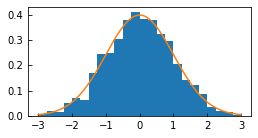

In [38]:
normal_hist(0, 1, 1000)

To determine bin width / size, I called the knuth method.
Above, we see a standard normal curve plotted against a histogram made of 1000 samples from the distribution.
Likely, as n tends to infinity, we will get convergence to the curve. 

### Exercise 2 (20 points): drawing pseudo-random numbers following a given distribution.

**Background: the inverse transform method.** There is a class of algorithms to generate random numbers drawn from a given distribution function. All of these algorithms are based on the algorithm to generate uniformly distributed random numbers that is described in <a href="06a_prngs.ipynb"><tt>06a_prngs.ipynb</tt></a> notebook and will be discussed in class on Wednesday. 

One of the most commonly used algorithms to draw samples from a given 1-dimensional distribution $p(x)$ is called *the inverse transform method,* which uses the cumulative distribution function of the target pdf $p(x)$ normalized to 1 at some interval $[a,b]$ that we want to sample:

$$F(\xi) = \int\limits_{a}^\xi p(x) dx;\ \ \ \mathrm{where}\ \ \xi\in[a,b],\ F\in[0,1],\ \ \mathrm{and}\ \  \int\limits_a^b p(x)dx =1$$

to generate samples of $p(x)$. Namely, if $y=F(\xi)$ can be inverted either analytically or numerically so that we can easily compute $\xi$ given a value of $y=F(\xi)$, then $\xi$ will be samples of $p(x)$, if $y$ are samples of the uniform distribution defined on the interval $[0,1)$. 

See <a href="06c_distribution_sampling.ipynb"><tt>06c_distribution_sampling.ipynb</tt></a> notebook for details on the history and logic behind this method. 

**Task 2a (10 points).** 
Write a routine to sample the following distribution that depends on parameter $a$: 

$$g(x)=
 \begin{cases}
            1/\sqrt{x},&\  \mathrm{for}\ \ x\in[1/a,a],\\
            0, &    \mathrm{otherwise.\ }
    \end{cases}$$
    
Note that the above distribution is *not* a pdf, because it is not normalized to 1.0 on the interval $[1/a,a]$. Thus, you should compute the normalization constant first. You should also compute the cumulative distribution function $F(x)$ for the normalized $\tilde{g}(x)$ and its inverse.   

Your routine should take as input parameter $a$ and the number of samples, $N_s$, to be generated and return a vector of $N_s$, pseudo-random numbers distributed with $g(x)$ distribution, for example:

    def gdist(nrnd = 1, a = 2.0):
        """
        function to sample distribution g(x) = 1/sqrt(x) for x in [1/a,a] and g(x)=0 otherwise.
    
        Parameters:
        -----------
        nrnd: integer (default is 1)
            number of pseudo-random draws of g(x) to generate
        a: real 
           parameter defining the range of the distribution (see above
       
        Returns: 
        --------
        a numpy real 1d vector of size nrnd
        (pseudo-random numbers distributed with g(x), as defined above 
    
    """
    
For efficiency, your routine must be written using numpy vector operations and should not use loops. 

The vector of <tt>nrnd</tt> uniformly distributed pseudo-random numbers in the interval $[0,1)$ can be generated using routine <a href="https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.uniform.html"><tt>numpy.random.uniform</tt></a> as 
    
    yrnd = np.random.uniform(size=nrnd)

Note that the sampling routine you develop here will be used in the implementation of the "affine-invariant" Markov Chain Monte Carlo (MCMC) sampling method of Goodman & Weare as part of the homework 4 assignment.  This is yet another example of a simpler method problem used as an element of a more complex algorithm. 

**Goal**: Find $c$ such that 
$$c \int_{\mathcal{R}} f(x) \,dx = c \int_{\frac{1}{a}}^{a} \frac{1}{\sqrt{x}} \,dx = 1.$$
Taking the definite integral and re-arranging yields
$$c = \frac{\sqrt{a}}{2(a - 1)}.$$
We see that $c$ is not defined at $a = 1$, but this is ok, since the density would not make sense if $a = 1$ (as the CDF would be 0 everywhere). 

The CDF $F(x)$ is $$c \int_{-\infty}^{x} f(x) \,dx = 2c \left(\sqrt{x} - \sqrt{\frac{1}{a}}\right),$$
for $x \in [-\frac{1}{a}, a]$.

We also note that if $F(x) = y$, then $x = F^{-1}(y) = \left(\frac{y}{2c} + \sqrt{\frac{1}{a}}\right)^2$.

It's easy to see that this function is invertible, so we proceed with the inverse method.

In [64]:
def gdist(nrnd = 1, a = 2.0):
    """
    function to sample distribution g(x) = 1/sqrt(x) for x in [1/a,a] and g(x)=0 otherwise.

    Parameters:
    -----------
    nrnd: integer (default is 1)
        number of pseudo-random draws of g(x) to generate
    a: real 
       parameter defining the range of the distribution (see above

    Returns: 
    --------
    a numpy real 1d vector of size nrnd
    (pseudo-random numbers distributed with g(x), as defined above 

    """
    y = np.random.uniform(size = nrnd)
    c = np.sqrt(a) / 2 / (a - 1)
    x = (y / (2 * c) + np.sqrt(1 / a)) ** 2
    return x

In [68]:
def plot_samples(func, samples, test, *args):
    """
    Plots samples against pdf of distribution.
    Histogram is made from samples
    Line Plot is made from (test, PDF(test)).
    """
    ### Bin Data
    h_k, bins_k = knuth_bin_width(samples, return_bins = True)
    num_bins = np.shape(bins_k)[0] - 1
    domain = (samples.min(), samples.max())
    
    density = func(test, *args)
    
    ### Plot!
    fig = plt.figure(figsize = (4,2))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.hist(samples, num_bins, domain, density = True)
    ax1.plot(test, density)

In [60]:
def inv_sqrt_pdf(x, a):
    """
    PDF (see task)
    """
    c = np.sqrt(a) / 2 / (a - 1) 
    return c * 1 / np.sqrt(x)

Optimization terminated successfully.
         Current function value: 2.556310
         Iterations: 15
         Function evaluations: 42


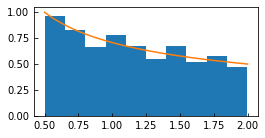

In [70]:
a = 2 
plot_samples(inv_sqrt_pdf, gdist(1000), np.linspace(1 / a, a, 1000), 2)

**Task 2b (10 points).** Suppose we want to draw samples from a more complicated pdf, $p(x) = A x^{-\alpha}\exp[-x/b]$, for which cumulative distribution function cannot be inverted analytically. 

Design and describe strategy to use the inverse transform method in such case using techniques you have already learned in this course (3 points). Implement sampling of this function using your strategy and demonstrate that your samples follow the target distribution using histogram of the samples (i.e., test similar to that used for the Gaussian distribution in 1c above). (7 points)

**The support of $p(x)$ isn't specified, so I will assume it's [0.01, 1]**. 

If the support is otherwise, simply change 0 and 1 to be parameters x0, x1 in my functions below. 

**Discussion**: We can't analytically integrate the density to get the CDF, but we can approximate the CDF with a spline. From Homework 3, we figured out that we can construct a spline that maps $y$ training points to $x$ training points. 
Thus, the spline is a function of $y$. So, we can choose numbers $y \sim \text{Uniform}[0, 1]$, plug them into the spline and get samples back. 

We could probably do regression instead of a spline. But we already did an implementation for splines, so I'll reference that.

Note: The CDF is monotonically increasing, so the monotone assumption is verified.

**Plan of Attack**: 
* Use Spline integral routine to integrate PDF over support. Return a spline and the normalization constant.
* Integrate the spline at a few test points to get a few CDF values. 
* Create a cubic spline mapping CDF values to test points. 
* Solve. 

**Extension** (For later):
* Make a class called density. 
* Initialize with pdf and bounds of support [x0, x1].
* Methods:
    * Draw samples (task 1)
    * Calculate cdf (task 2)
    * Plot pdf (task 1)
    * Plot cdf (task 2)

In [222]:
def p(x, a, b):
    """
    PDF (see task 2b)
    """
    return np.power(x, - a) * np.exp(- x / b)

def norm_constant(pdf, x0, x1, ntr, *args):
    """
    Suppose PDF is supported on [x0, x1]
    To compute the constant (to make it a valid density),
    create a spline (samples -> pdf) and integrate the spline
    over the support [x0, x1].
    
    Return constant, spline. 
    """
    x_pts = xtr(ntr, "chebyshev1", x0, x1)
    density = pdf(x_pts, *args)
    
    Spl = UnivariateSpline(x_pts, density, s = 0)
    c = 1 / Spl.integral(x0, x1)
    return c, Spl

def cdf(pdf, x0, x1, ntr, *args):
    """
    Input pdf function supported on [x0, x1].
    Use ntr training points to compute the PDF constant
    and create a spline. Integrate the spline along various
    values (x_pts) in [x0, x1].
    
    Return array of x_pts, CDF values.
    """
    x_pts = xtr(ntr, "chebyshev1", x0, x1)
    c, Spl = norm_constant(pdf, x0, x1, ntr, *args)
    CDF = np.zeros(x_pts.shape)
    for i, x in enumerate(x_pts):
        CDF[i] = Spl.integral(x0, x) * c
    return x_pts, CDF

In [199]:
def new_p(x, a, b, constant):
    """
    PDF (see task2b) with constant included.
    """
    return p(x, a, b) * constant

In [196]:
def inverse_cdf(y, pdf, x0, x1, ntr, *args):
    """
    Input y (CDF values), pdf supported on [x0, x1]
    and trained using ntr number of training points.
    
    Create a spline (CDF -> samples). 
    
    Plug in y ino this spline to get samples.
    Return samples.
    """
    x_pts, CDFs = cdf(pdf, x0, x1, ntr, *args)
    inv_Spl = UnivariateSpline(CDFs, x_pts)
    inv_Spl_vec = np.vectorize(inv_Spl)
    return inv_Spl(y)   

In [181]:
# Constant, Spline
norm_constant(p, 0.01, 1, 11, 0.01, 1.01)

(1.5994328519721623,
 <scipy.interpolate.fitpack2.InterpolatedUnivariateSpline at 0x1ed1640f7b8>)

In [182]:
# x_training points (samples), y_training points (CDFs)
cdf(p, 0.01, 1, 15, 0.01, 1.01)

(array([0.01271166, 0.03422702, 0.07631743, 0.13714331, 0.2140463 ,
        0.30366536, 0.40208371, 0.505     , 0.60791629, 0.70633464,
        0.7959537 , 0.87285669, 0.93368257, 0.97577298, 0.99728834]),
 array([0.        , 0.03475268, 0.10002623, 0.18911278, 0.2937852 ,
        0.40569171, 0.51731833, 0.62271158, 0.71769886, 0.79977737,
        0.86777803, 0.92145127, 0.96107052, 0.98710794, 1.        ]))

In [214]:
samples = inverse_cdf(np.linspace(0.01, 1, 10000), p, 0.01, 1, 15, 0.01, 1.01)

In [207]:
def plot_samp(func, samples, test, bins, *args):
    """
    Same as plot_samples but bins are user-specified.
    """
    domain = (samples.min(), samples.max())
    density = func(test, *args)
    
    ### Plot!
    fig = plt.figure(figsize = (4,2))
    ax1 = fig.add_subplot(1, 1, 1)
    ax1.hist(samples, bins, domain, density = True)
    ax1.plot(test, density)

Optimization terminated successfully.
         Current function value: -359.447339
         Iterations: 21
         Function evaluations: 54


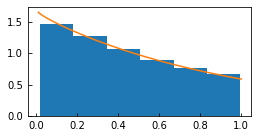

In [215]:
plot_samples(new_p, samples, np.linspace(0.01, 1, 1000), 0.01, 1, 1.5994328519721623)

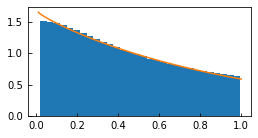

In [221]:
# Same plot with 30 bins. 
plot_samp(new_p, samples, np.linspace(0.01, 1, 1000), 30, 0.01, 1, 1.5994328519721623)

### Exercise 3: implementing and testing a Differential Evolution algorithm (25 points + 10 extra-credit points)

The differential evolution (DE) algorithm discussed on Friday and can be described by the following pseudo-code: 

    def minimize_by_differential_evolution(func, x0, atol=1.e-6, s=1.0, bounds=None)
        """
        Parameters:
        ------------
        func - Python function object
               function to minimize, should expect x0 as a parameter vector
        x0   - vector of real numbers of shape (npop, nd), 
                where npop is population size and nd is the number of func parameters
        atol - real
                absolute tolerance threshold for change of population member positions
        s    - real 
                mean of the scaling parameter s
        sigs - real 
                rms dispersion of s for drawing Gaussian random numbers center on s
        bounds - array of tuples 
                bounds for the minimization exploration; define the region in which to search for the minimum
        """
        npop = np.size(x0)[0] # the number of population members
        xnow = np.copy(x0)
        fnow = func(xnow)
        xnext = np.zeros_like(xnow)
        #....
        while some convergence criterion is not met: 
            # xnow is a vector of coordinate vectors of the current population
            # xnext is a vector of coordinate vector of the next gen population
            for i in range(npop):
                # generate random indices  ir1, ir2, ir3 
                # where all indices are not equal to each other and not equal to i
                # s can be a constant for large npop, but it's more safe to make it a Gaussian random number
                xtry = xnow[ir3] + s * (xnow[ir1] - xnor[ir2])
                if xtry is within bounds and func(xtry) <= fnow[i]:
                    xnext[i] = xtry
                else:
                    xnext[i] = xnow[i]
                
        return xnext
        
As we can see, the algorithm is quite simple, but it requires generation of unique random indices ir1, ir2, ir3 different from each other and from i, as well as a random Gaussian number to be used for scaling parameter s for reasons that are described in <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook. 

**Task 3a. (20 points)** Use pseudo-code of the DE algorithm in exercise 1 to implement DE minimization routine with the following interface (15 points):
        
Try to "vectorize" as much of the algorithm as possible.
        
Assuming that we are searching for a minimum within some rectangular domain defined by the minimum and maximum values along each coordinate axis: $\mathbf{x}_{\rm min}$ and $\mathbf{x}_{\rm max}$, we can initialize the population members as 

$$\mathbf{x}_0 = \mathbf{x}_{\rm min} + (\mathbf{x}_{\rm max}-\mathbf{x}_{\rm min}) \times \mathrm{rand}(0,1),$$

where $\mathrm{rand}(0,1)$ is a random number uniformly distributed from 0 to 1, generated using <tt>np.random.uniform</tt>.  

Test your implementation in 2D and 5D using the Rosenbrock function similarly how optimization routines were tested in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook and present results of your tests along with your implementation (2 points). 

Experiment with the size of the population and values of the parameter $s$ timing how long it takes your function to find the minimum. Are the results robust to population size and $s$? Briefly describe results of your findings (3 points). If you do not succeed implementing routine fully, you can still do this part of the task using routine <tt>scipy.optimize.differential_evolution</tt>, as illustrated in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook.

For intuition:
* https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
* https://en.wikipedia.org/wiki/Differential_evolution

In [2]:
def rand_indicies(xnow, i):
    # xnow is a vector of coordinate vectors of the current population
    # i is in range of population size
    # generate random indices  ir1, ir2, ir3 
    # access members of the population at x[ir1], x[ir2], x[ir3]
    # return these 3 memebers of the population
    
    npop = np.shape(xnow)[0]  #population size
    inds = np.zeros((npop-1)) # store indices here

    counter = 0
    for ind in range(npop):
        if (ind != i): # where all indices are not equal to each other and not equal to i
            inds[counter] = ind
            counter += 1 # we use a counter as an index for clarity
                
    rand_ind = np.random.choice(inds, 3, replace = False)
    # from inds, the array of stored indices
    # randomly choose 3 indicies of inds
    
    ind1 = rand_ind[0]
    ind2 = rand_ind[1]
    ind3 = rand_ind[2]
    
    # So we have an array of indicies and 3 random indices
    # we use those 3 to pull 3 indices from the array
    # Using those 3 random indices, we pull from the population

    xnow_r1 = xnow[int(ind1), :]
    xnow_r2 = xnow[int(ind2), :]
    xnow_r3 = xnow[int(ind3), :]
    
    return xnow_r1, xnow_r2, xnow_r3

In [3]:
def inbounds(arr1, bounds):
    return ((arr1 >= bounds[:, 0]) & (arr1 <= bounds[:, 1])).all(1).sum()

In [369]:
a.shape

(1, 2)

In [377]:
b.shape

(3, 2)

In [376]:
a = np.array([[1, 3, 4]])
b = np.array([[0, 2], [1, 4], [3, 5]])
print(a, "\n")
print(b)
inbounds(a, b)

[[1 3 4]] 

[[0 2]
 [1 4]
 [3 5]]


1

In [338]:
b = np.array([[-1, 0], [1, 4]])
print(b)
inbounds(a, b)

[[-1  0]
 [ 1  4]]


0

In [4]:
def L2_loss(func, val1, val2):
    """
    Compute L2 Error of val1, val2.
    """
    npop = np.shape(val1)[0]
    L2_err = np.zeros((npop, 1))
    for i in range(npop):
        diff = func(val1[i,:]) - func(val2[i,:])
        L2_err[i] = np.power(diff, 2)
    return np.amax(L2_err)

def rosenbrock(x):
    """The Rosenbrock "banana" function
    x is a vector of points in 2 or more dimensional space
    """
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

**From the Lecture 5 Notebook**:
Start with $N_p$ members of the population randomly distributed in the
problem domain. Vector of coordinates for each member is indexed from
$0$ to $N_p-1$ and collection of all vectors 
$\mathbf{X}_{\rm now}=(\mathbf{x}_{\rm now,0},\mathbf{x}_{\rm now,1},\ldots,\mathbf{x}_{{\rm now},N_p-1})$ forms the current population, where each $\mathbf{x}_{\rm now,i}$ is a $D$-dimensional vector, where $D$ is the number of parameters of the minimized function.

In [5]:
def init_x0(xmin, xmax, npop, ndim):
    '''
    See the note above for the intuition.
    Used to initialize the data before we run differential
    evolution. 
    We want x0 to be a vector of real numbers of shape (npop, nd), 
    where npop is population size and nd is the number of func parameters.
    '''
    assert(xmin != xmax)
    #We find the difference between xmax and xmin.
    #We reshape the array into (npon, ndim)
    
    xdomain = np.reshape(np.repeat(xmax - xmin, npop * ndim), (npop, ndim))
    
    rand_vec = np.random.uniform(low = 0, high = 1, size=npop)
    rand_vec = np.reshape(np.repeat(rand_vec, ndim), (npop, ndim))
    
    x0 = xmin + xdomain * rand_vec
    return x0

In [6]:
def minimize_by_differential_evolution(func, x0, atol =1.e-6, s=1.0, sigs=0.1, bounds = None, max_iter = 250, *args):
    """
    Parameters:
    ------------
    func - Python function object
           function to minimize, should expect x0 as a parameter vector
    x0   - vector of real numbers of shape (npop, nd), 
            where npop is population size and nd is the number of func parameters
    atol - real
            absolute tolerance threshold for change of population member positions
    s    - real 
            mean of the scaling parameter s
    sigs - real 
            rms dispersion of s for drawing Gaussian random numbers center on s
    bounds - array of tuples 
            bounds for the minimization exploration; define the region in which to search for the minimum
    max_iter = maximum number of iterations
    """
    
    xnow = np.copy(x0) # xnow is a vector of coordinate vectors of the current population
    xnext = np.zeros_like(xnow) # xnext is a vector of coordinate vectors of the next gen population
    npop = np.shape(xnow)[0] #num of population member
    fnow = np.zeros((npop))
    ndim = np.shape(xnow)[1] # num dimensions
    
    for i in range(npop):
        fnow[i] = func(xnow[i, :], *args)
    # Each element of fnow is (1, nd)
    # It's a value of x from xnow for each dimension. 
    
    # Store results here
    optimal_result = np.repeat(6, ndim)
    
    iters = 0
    while (L2_loss(func, xnow, xnext) > atol):
        #while some convergence criterion is not met
        for i in range(npop):
            #generate random indices ir1, ir2, ir3
            xnow_r1, xnow_r2, xnow_r3 = rand_indicies(xnow, i)
            
            # s can be a constant for large npop
            # safer to make it gaussian random number
            s_gauss = np.random.normal(loc = s)
            
            # MUTATION
            xtry = xnow_r3 + s_gauss *(xnow_r1 - xnow_r2)
            
            # SELECTION

            in_range = True
            if bounds is not None:
                xtry2 = xtry.reshape((1, xtry.size))
                in_range = inbounds(xtry2, bounds)
                
            if (func(xtry, *args) <= fnow[i]) and in_range: 
                xnext[i] = xtry
            else:
                xnext[i] = xnow[i]
            
            #updating our best result
            if func(xtry, *args) < func(optimal_result, *args):
                optimal_result = xtry
        
        # ERROR CALCULATION
        xnow_temp = np.copy(xnow)
        xnow = np.copy(xnext)
        for i in range(npop):
            fnow[i] = func(xnow[i, :], *args)
        xnext = xnow_temp 
    
        if iters > max_iter:
            print("Maximum Iterations Achieved! Ending loop now.")
            break
        
        iters += 1
            
    return optimal_result

In [7]:
def test_rosenbrock(ndim, npop, xmin, xmax, bounds = None):
    """
    Tests the differential evolution algorithm on the Rosenbrock function
    in ndim dimensions. 
    
    See documentation for init_x0 for more details.
    """
    x0 = init_x0(xmin, xmax, npop, ndim)
    t1 = default_timer()
    optimal_result = minimize_by_differential_evolution(rosenbrock, x0, atol=1.e-10)
    t2 = default_timer()

    print("Finished in %.3g sec" % (t2 - t1))
    print("Minimum at :", optimal_result)
    
test_rosenbrock(ndim = 2, npop = 100, xmin = -10, xmax = 10)

Finished in 0.408 sec
Minimum at : [0.99999967 0.99999967]


In [400]:
bdd = np.array([[-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]])
bdd = bdd.reshape((5,2))

test_rosenbrock(ndim = 5, npop = 100, xmin = -15, xmax = 10, bounds = bdd)

Finished in 0.359 sec
Minimum at : [0.99999991 0.99999991 0.99999991 0.99999991 0.99999991]


**Discussion**: In both 2d and 5d, the differential evolution algorithm runs at roughly the same amount of time (with the 5d case being a little slower).

**Task 3b (5 points).** Use the DE routine you implemented to find the minimum of the $\chi^2$ function as a function of $\Omega_{\rm m0}$, $\Omega_\Lambda$, and $\tilde{M}_0$ that you used in hw 3. Check that results you get are similar to what you obtained in hw 3. 

If you do not succeed implementing routine fully, you can still do this part of the task using routine <tt>scipy.optimize.differential_evolution</tt>, as illustrated in the <a href="05_optimization.ipynb"><tt>05_optimization.ipynb</tt></a> notebook.

In [8]:
from codes.read_data import read_jla_data

# you may need to change slash in the file name below on your system
# read vectors of redshifts, apparent magnitude in B-band, mB, and its uncertainty emB:

zCMB, mB, emB = read_jla_data(sn_list_name = 'data/jla_lcparams.txt')

print("read sample of %d supernovae..."% (np.size(zCMB)))

read sample of 740 supernovae...


In [9]:
from codes.constants import clight

def init_chisq(npop):
    """
    Data preparation for the differential evolution algorithm
    on the chi-square function.
    
    npop = population size
    """

    rand1 = np.random.uniform(size = npop)
    rand2 = np.random.uniform(size = npop)
    rand3 = np.random.uniform(size = npop)

    Om0_min = 1e-3; Om0_max = 1
    OmL_min = 1e-3; OmL_max = 1
    H0 = 70
    tM0_min = -19.6 + 5 * np.log10(clight / H0) + 25
    tM0_max = -18.6 + 5 * np.log10(clight / H0) + 25

    Om0_init = Om0_min + np.repeat((Om0_max - Om0_min), npop) * rand1
    OmL_init = OmL_min + np.repeat((OmL_max - OmL_min), npop) * rand2
    tM0_init = tM0_min + np.repeat((tM0_max - tM0_min), npop) * rand3

    x0 = np.vstack((Om0_init, OmL_init, tM0_init))
    return np.transpose(x0)

In [82]:
from codes.cosmology import d_l

def chi_sqr(x0):
    Om0 = x0[0]; OmL = x0[1]; tM0 = x0[2]
    dL = d_l(zCMB, Om0, OmL)
    #if np.isnan(dL).any():
     #   return 1e10
    mue_delta = mB - 5 * np.log10(dL)- tM0
    chi_sqr = np.power(mue_delta/emB, 2)
    return np.sum(chi_sqr)

In [52]:
def dlz_initialize(zCMB, method = 'chebyshev1', ntr = 13, px = 13, py = 13):
    """
    Stores Polynomial coefficients for each value of z in zCMB into an array
    dLZ. Returns dLZ. 
    Input data (zCMB)
    Spacing (method) for nodes
    Number of training points (ntr)
    Order of polynomial (px, py)
    """
    Om0tr = xtr(ntr, method)
    OmLtr = xtr(ntr, method)
    dLz = np.zeros((1, ntr + 1, ntr + 1))
    
    for iz, zi in enumerate(zCMB):
        dL_coeffs = dL_poly_approx(zi, ntr)
        dL_coeffs = np.reshape(dL_coeffs, (1, px + 1, py + 1))
        #print(dLz.shape, dL_coeffs.shape)
        dLz = np.append(dLz, dL_coeffs, axis = 0)
        print(iz)

    # by the end of this you should have a list of N_SN = np.size(zCMB) approximations
    # you can convert it from list to numpy array if needed as
    # dLz = np.asarray(dLz)

    return dLz[1:, :]

dLz_coeffs = dlz_initialize(zCMB)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [86]:
vals = init_chisq(npop = 20)
min_chi_sqr = minimize_by_differential_evolution(chi_sqr, vals, bounds = bdd)

!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(

!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(

!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(

!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(err)=nan, > required error rtol = 1.000e-10
!!! Romberg warning: !!!
!!! maximum of mmax=16 iterations reached, abs(

In [87]:
min_chi_sqr

array([ 0.37497773,  0.32251862, 24.1083304 ])

In [85]:
bdd = np.array([[1e-3, 1], [1e-3, 1], [1e-3, 30]])
bdd = bdd.reshape((3,2))

**Discussion**: Our results are very similar to those from the last homework.

In the last homework, I found (Om0, OmL, tM0) = (0.364, 0.394, 24.104).
Here, I found (Om0, OmL, tM0) = (0.374, 0.323, 24.108).

The Romberg routine was not able to reached the desired accuracy at times. After some digging, I realized I was getting nan values for the integral, likely from attempting to take a logarithm of a negative number. 

I attempted polynomial approximation instead and was faced with a similar error. 

**Task 3c (extra-credit 15 points).** If you implement DE minimization routine successfully in 3a, you can parallelize it using MPI routines by parallelizing mutation and selection stages during each evolutionary iteration for subsets of the population members, similarly to the parallelization of the integration described in the extra-credit exercise in hw 1. 

Present parallelized implementation and tests showing 1) that it works identically to the unparallelized version and 2) timing showing how the execution time scales with the number of MPI processes on different number of processing cores. 

**TBD**